In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import data_modeling as dmod
import data_analysis as dan

# Load data

In [2]:
# Load the forecasting model data 
data = pd.read_csv('../data/ml_data_panel.csv')

# Ensure sector is categorical once (helps consistency)
data = data.astype({'sector': 'category'})
data = data.astype({'subsector': 'category'})
# Load feature labels
labels = dan.load_char_labels()
identifiers = ['tic', 'conm', 'year', 'month', 'date']
stock_chars, acc_ratios = labels['stock_chars'], labels['acc_ratios']
targets = ['target_exret']

# Remove redundant or problematic features
acc_ratios = data.columns[data.columns.isin(acc_ratios)].to_list()

# Prep data

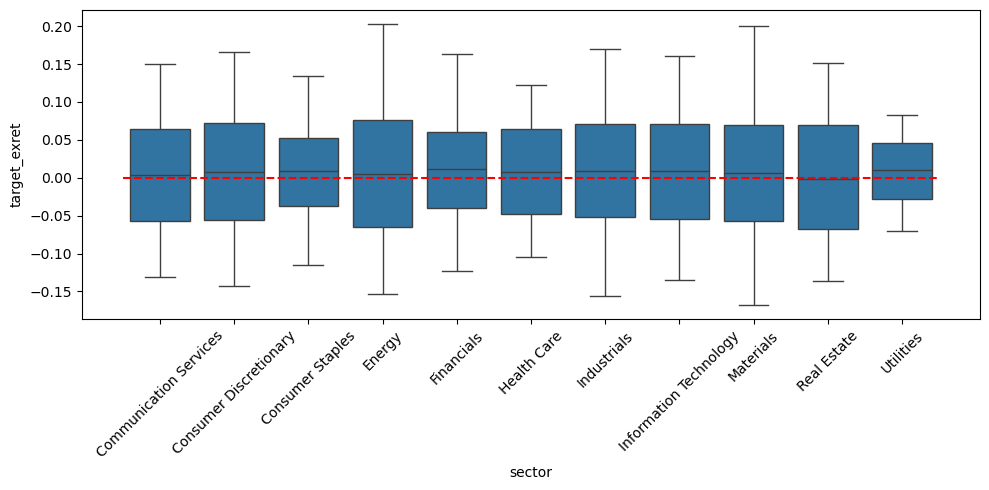

In [3]:
# Set the date type and create a proper date column
data['date'] = pd.to_datetime(data[['year','month']].assign(DAY=1))

# Winsorize the target variable within each subsector. May be for classification, since target_exret is ultimately binned, clipping won't add value.
data_winsorized = dmod.winsorize_target(data, target='target_exret', lower=0.1, upper=0.9)

plt.figure(figsize=(10,5))
ax = sns.boxplot(data=data_winsorized,
             x="sector", 
             y="target_exret")

ax.set_xlabel("sector"); ax.set_ylabel("target_exret")
ax.tick_params(axis='x', rotation=45)
plt.hlines(y=0, xmin=-0.5, xmax=len(data['sector'].unique())-0.5, colors='r', linestyles='dashed')
plt.tight_layout(); plt.show()

In [4]:
import screen_and_filter as sf

path_to_glossary = "~/Documents/folio/gill-hack/2025/ASSET MANAGEMENT HACKATHON 2025/stock_char_appendix/table1.csv"

res = sf.build_universe(data,
        path_to_glossary,
        min_dolvol=2_000_000,     # tighten to 5_000_000 for higher capacity / lower slippage
        min_turnover=0.001,
        mcap_lo_pct=0.20,
        mcap_hi_pct=0.95,
        min_months_hist=36,       # history requirement (months)
        vol_trim_pct=0.90,        # drop top 10% most illiquid/volatile names per sector-date
        picks_per_sector=40,      # LO shortlist size per sector
        subsector_cap_frac=0.40   # no subsector > 40% of sector shortlist
        )

# Outputs:
LO_universe = res['shortlist_balanced']    # sector & subsector-balanced long-only candidates
LS_universe = res['ls_marks']              # screened base marked with long/short deciles
Screened    = res['screened_universe']     # full screened tradable base w/ alpha_score


/home/ramiuness/Documents/folio/gill-hack/2025/ASSET MANAGEMENT HACKATHON 2025/code/screen_and_filter.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby(['date','sector'], group_keys=False).apply(_band).reindex(df.index)
/home/ramiuness/Documents/folio/gill-hack/2025/ASSET MANAGEMENT HACKATHON 2025/code/screen_and_filter.py:77: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby(['date','sector'], group_keys=False).apply(_trim).reindex(df.index)
/home/ramiuness/Documents/folio/gill-hack/2025/ASSET MANAGEMENT HACKATHON 2025/code/screen_and_filter.py:107: FutureWarning: The defau

In [7]:
data = data.loc[data.tic.isin(Screened.tic.to_list())]
#             .merge(Screened[['date','tic','alpha_score']],
#                     on=['date','tic'], how='left')
# )

# from sklearn.preprocessing import MinMaxScaler
# # ensure alpha_score exists and finite
# alpha_clipped = data['alpha_score'].replace([np.inf, -np.inf], np.nan).fillna(0).clip(lower=-3, upper=3)

# # normalize to [0.2, 1.0] so weights never drop to zero
# scaler = MinMaxScaler((0.2, 1.0))
# data['alpha_score'] = scaler.fit_transform(alpha_clipped.values.reshape(-1, 1)).flatten()

In [ ]:
# plt.figure(figsize=(10, 5))
# order = (data.groupby('sector', observed=False)['alpha_score']
#             .median()
#             .sort_values()
#             .index)
# ax = sns.boxplot(data=data, x='sector', y='alpha_score', order=order)
# ax.set_xlabel('Sector'); ax.set_ylabel('Alpha score')
# ax.tick_params(axis='x', rotation=45)
# plt.tight_layout(); plt.show()

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 226561 entries, 0 to 247592
Data columns (total 29 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   date           226561 non-null  datetime64[ns]
 1   year           226561 non-null  int64         
 2   month          226561 non-null  int64         
 3   tic            226561 non-null  object        
 4   conm           226561 non-null  object        
 5   sector         226561 non-null  category      
 6   subsector      226561 non-null  category      
 7   market_equity  226561 non-null  float64       
 8   dolvol_126d    226561 non-null  float64       
 9   turnover_126d  226561 non-null  float64       
 10  ivol_ff3_21d   226561 non-null  float64       
 11  ni_ivol        226561 non-null  float64       
 12  beta_60m       226561 non-null  float64       
 13  z_score        226561 non-null  float64       
 14  f_score        226561 non-null  float64       
 15  netde

# =======================================================================
# Time-aware CV with Purge & Embargo + LightGBM (Classification: Up/Down)
# =======================================================================

In [9]:
# GBM hyperparameters (binary classification)
num_boost_round = 500

params = {
    'objective': 'binary',
    'metric': ['auc', 'binary_logloss'],
    'class_weight': 'balanced',
    'num_leaves': 50,
    'learning_rate': 0.05,
    'num_iteration': 1000,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.9,
    'bagging_freq': 1,
    'verbose': -1,
}

# Features / targets
feats = stock_chars + acc_ratios + ['sector'] #+ ['alpha_score']

categorical_features = ['sector']
target_bin  = 'target_up'      # new binary label (1 if up, 0 otherwise)
date_col    = 'date'

# Derive binary target once
data = data.query("'2005-01-01' <= date <= '2012-12-31'").copy() # safeguard
data[target_bin] = (data['target_exret'] > 0).astype(int)

# Ensure sector is categorical 
data.loc[:, 'sector'] = data['sector'].astype('category')

In [11]:
# Collect fold predictions and report per-fold metrics
folds, models, fold_metrics = dmod.compute_lgb_clf_cv_metrics(
    data=data,
    date_col=date_col,
    feats=feats,
    target=target_bin,  
    params=params,
    cat_cols=categorical_features,
    num_boost_round=num_boost_round,
    n_splits=5,
    purge=2,
    embargo=2
)   

fold_df = pd.DataFrame(fold_metrics)
print("Per-fold metrics:\n", fold_df)
print("\nCV mean perf | ACC: {:.4f}, AUC: {:.4f}, F1: {:.4f}, P: {:.4f}, R: {:.4f}".format(
    fold_df['acc'].mean(), fold_df['auc'].mean(), fold_df['f1'].mean(),
    fold_df['precision'].mean(), fold_df['recall'].mean()
))

Per-fold metrics:
         acc       auc        f1  precision    recall
0  0.535163  0.521846  0.688550   0.536891  0.959619
1  0.515902  0.531184  0.668540   0.513673  0.957093
2  0.501531  0.514283  0.643589   0.503536  0.891571
3  0.597076  0.538856  0.727779   0.622123  0.876665
4  0.533651  0.520005  0.695307   0.533532  0.997878

CV mean perf | ACC: 0.5367, AUC: 0.5252, F1: 0.6848, P: 0.5420, R: 0.9366


In [12]:
oof_proba, oof_pred, oof_metrics = dmod.compute_lgb_clf_oof_metrics(data, folds, models, feats, target_bin)
print("\nOOF perf     | ACC: {:.4f}, AUC: {:.4f}, F1: {:.4f}, P: {:.4f}, R: {:.4f}".format(
        oof_metrics['ACC'], oof_metrics['AUC'], oof_metrics['F1'], oof_metrics['Precision'], oof_metrics['Recall']
    ))### No observed beneifit for using the alpha score as weight in the lgb clf. may well revert to initial setup but still use Screened.


OOF perf     | ACC: 0.5374, AUC: 0.5228, F1: 0.6860, P: 0.5417, R: 0.9350


In [ ]:
# Choose the probability threshold for classification (default 0.5)
probability_threshold = 0.5

In [13]:
data.tic.nunique()

947

In [ ]:
from tuning import tune_lightgbm_classifier, SearchSpace

space = SearchSpace()  # or customize ranges

out = tune_lightgbm_classifier(
    data=data,
    feats=feats,
    target_bin=target_bin,
    date_col=date_col,
    categorical_features=categorical_features,
    time_block_splits=dmod.purged_kfold_with_embargo,
    fit_lgb_fold_clf=dmod.fit_lgb_fold_clf,
    n_splits=5,
    purge=1,
    embargo=0,
    base_params={"learning_rate": 0.05, "boosting": "gbdt"},  # optional tweaks
    search_space=space,
    n_trials=80,  # coarse search trials
    learning_rate_coarse=0.05,
    k_ratio=0.10,  # top 10% for Top-k metrics
    threshold_objective="f1",
    y_ranker_col=None,        # or "target_exret_next" if you want IC
    final_strategy="ensemble" # "ensemble" (recommended) or "single_refit"
)

print("Best params:\n", out.best_params)
print("Global decision threshold (median across folds):", out.global_threshold)
print("Median best_iteration across folds:", out.best_best_iteration_median)
print("Refit strategy:", out.refit_strategy)

# Leaderboard of all tried configs (sorted by PR-AUC in the function already)
display(out.leaderboard.head(10))

# Per-fold metrics for the selected config:
display(out.best_fold_stats)
